In [ ]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pydicom as dicom
import pydicom
import json
import glob
import collections
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import plotly.graph_objects as go
import random
from glob import glob
import warnings
from PIL import Image
import tensorflow as tf
import ssl
from keras.src.layers import Flatten, Dense, Concatenate
from keras import Model, Input

In [ ]:
# label_coordinates_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
# train_series = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')
# df_train = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
# df_sub = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/sample_submission.csv')
# test_series = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_series_descriptions.csv')

base_path = '/Volumes/SSD/rsna-2024-lumbar-spine-degenerative-classification'
train_png_file_path = f'{base_path}/train_dataset_png'

label_coordinates_df = pd.read_csv(f'{base_path}/train_label_coordinates.csv')
train_series = pd.read_csv(f'{base_path}/train_series_descriptions.csv')
df_train = pd.read_csv(f'{base_path}/train.csv')
df_sub = pd.read_csv(f'{base_path}/sample_submission.csv')
test_series = pd.read_csv(f'{base_path}/test_series_descriptions.csv')

train_dicom = f'{base_path}/train_images'
test_dicom = f'{base_path}/test_images'

In [ ]:
# パラメータ
CROP_SIZE = 64

# 出力のラベル
NORMAL_MILD = 0
MODERATE = 1
SEVERE = 2

# 重症度一覧
SEVERITY_LIST = ['Normal/Mild', 'Moderate', 'Severe']

# 学習用パラメータ
BATCH_SIZE = 16
EPOCHS = 100
TRAIN_RATIO = 0.8
VALID_RATIO = 0.1
TEST_RATIO = 0.1

# 入出力の形状
INPUT_WIDTH = 128
INPUT_HEIGHT = 128
INPUT_CHANNEL = 15

In [ ]:
train_series[train_series['study_id'] == 2492114990]

In [ ]:
print(f'train shape : {df_train.shape}')
# 含まれているデータすべてを重複なく表示
for column in df_train.columns:
    print(f'{column} : {df_train[column].unique()}')

In [ ]:
print(label_coordinates_df[label_coordinates_df['study_id'] == 4646740].shape)
label_coordinates_df[label_coordinates_df['study_id'] == 4646740]

In [ ]:
label_coordinates_df.shape

In [ ]:
# dicom画像をimageとして読み込む
def load_dicom_image(input_file_path: str):
    """
    dicom画像を読み込み, 画像を白黒反転して返す
    :param input_file_path: 
    :return: 
    """
    d = pydicom.dcmread(input_file_path)
    dicom_image = d.pixel_array

    dicom_image = np.clip(dicom_image, 0, 255)

    # 白黒反転
    dicom_image = 255 - dicom_image

    dicom_image = dicom_image.astype(np.uint8)

    return dicom_image

In [ ]:
def create_png(file_kind='train'):
    # dicom画像が保存されているフォルダのパス
    folder_base_path = f'{base_path}/{file_kind}_images'

    # df を1行ずつ読み込んで、dicom画像を読み込み, 座標を中心に画像を切り取る
    for index, row in label_coordinates_df.iterrows():

        # 処理の完了割合を表示
        if index % 100 == 0:
            print(f'index : {index}/{label_coordinates_df.shape[0]}')

        study_id = row['study_id']
        series_id = row['series_id']

        # print(f'study_id : {study_id}, series_id : {series_id}')
        instance_number = row['instance_number']

        # 小文字で condition を取得する
        condition = row['condition'].lower().replace(' ', '_')

        # / を _ に変換して level を取得
        level = row['level'].replace('/', '_').lower()

        # submission 用の row_id を作成
        row_id = f'{study_id}_{condition}_{level}'

        # dicom画像のフルパス
        dicom_full_path = f'{folder_base_path}/{study_id}/{series_id}/{instance_number}.dcm'

        x, y = int(row['x'] + CROP_SIZE), int(row['y'] + CROP_SIZE)

        # fileが存在するのか確認する
        if not os.path.exists(dicom_full_path):
            print(f'file not found : {dicom_full_path}')
            break

        # dicom画像を読み込む
        image = load_dicom_image(dicom_full_path)

        # 画像を中心に切り取る
        y_min = y - CROP_SIZE // 2
        y_max = y + CROP_SIZE // 2
        x_min = x - CROP_SIZE // 2
        x_max = x + CROP_SIZE // 2
        crop_image = image[y_min:y_max, x_min:x_max]

        # png形式でグレースケールで保存 (PILを使って保存)
        output_file_path = f'{train_png_file_path}/{row_id}.png'
        image_pil = Image.fromarray(crop_image)
        image_pil.save(output_file_path)

In [ ]:

# dicom 画像を pngに変換し保存しておく
def convert_dicom_to_png(data_kind="train"):
    data_dict = {}
    print(f'## convert_dicom_to_png : {data_kind}')
    # dicom画像が保存されているフォルダのパス
    folder_base_path = f'{base_path}/{data_kind}_images'

    # 保存するディレクトリ名
    save_folder_path = f'{base_path}/{data_kind}_images_png'

    # ディレクトリ一覧を取得
    study_ids = os.listdir(folder_base_path)

    # .DS_Store がある場合は削除
    if '.DS_Store' in study_ids:
        study_ids.remove('.DS_Store')

    # ディレクトリが存在しない場合は作成
    if not os.path.exists(save_folder_path):
        os.makedirs(save_folder_path)

    # ディレクトリ一覧をループ
    for study_id in study_ids:
        # 残りの処理数を表示
        print(f'study_id : {study_id}, remaining : {len(study_ids) - study_ids.index(study_id)}')

        # ディレクトリ一覧を取得
        series_ids = os.listdir(f'{folder_base_path}/{study_id}')

        data_dict[study_id] = {}

        # .DS_Store がある場合は削除
        if '.DS_Store' in series_ids:
            series_ids.remove('.DS_Store')

        # ディレクトリが存在しない場合は作成
        if not os.path.exists(f'{save_folder_path}/{study_id}'):
            os.makedirs(f'{save_folder_path}/{study_id}')

        # ディレクトリ一覧をループ
        for series_id in series_ids:

            # ディレクトリ一覧を取得
            instance_numbers = os.listdir(f'{folder_base_path}/{study_id}/{series_id}')

            # .DS_Store がある場合は削除
            if '.DS_Store' in instance_numbers:
                instance_numbers.remove('.DS_Store')

            # ディレクトリが存在しない場合は作成
            if not os.path.exists(f'{save_folder_path}/{study_id}/{series_id}'):
                os.makedirs(f'{save_folder_path}/{study_id}/{series_id}')

            # ディレクトリ一覧をループ
            for instance_number in instance_numbers:
                # dicom画像のフルパス
                dicom_full_path = f'{folder_base_path}/{study_id}/{series_id}/{instance_number}'

                # 保存するファイル名
                output_file_path = f'{save_folder_path}/{study_id}/{series_id}/{instance_number}.png'

                # dicom画像を読み込む
                image = load_dicom_image(dicom_full_path)

                # png形式でグレースケールで保存 (PILを使って保存)
                image_pil = Image.fromarray(image)
                image_pil.save(output_file_path)



In [ ]:
from keras.src import backend
from keras.src import layers
from keras.src.api_export import keras_export
from keras.src.applications import imagenet_utils
from keras.src.models import Functional
from keras.src.ops import operation_utils
from keras.src.utils import file_utils


def VGG16(
        include_top=True,
        weights="imagenet",
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000,
        classifier_activation="softmax",
):
    if not (weights in {"imagenet", None} or file_utils.exists(weights)):
        raise ValueError(
            "The `weights` argument should be either "
            "`None` (random initialization), 'imagenet' "
            "(pre-training on ImageNet), "
            "or the path to the weights file to be loaded.  Received: "
            f"weights={weights}"
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            "If using `weights='imagenet'` with `include_top=True`, "
            "`classes` should be 1000.  "
            f"Received classes={classes}"
        )

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # Get the number of input channels
    input_channels = input_shape[-1]
    # Block 1
    x = layers.Conv2D(
        64, (3, 3), activation="relu", padding="same", name="block1_conv1",
        input_shape=(None, None, input_channels)
    )(img_input)
    x = layers.Conv2D(
        64, (3, 3), activation="relu", padding="same", name="block1_conv2"
    )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block1_pool")(x)

    # Block 2
    x = layers.Conv2D(
        128, (3, 3), activation="relu", padding="same", name="block2_conv1"
    )(x)
    x = layers.Conv2D(
        128, (3, 3), activation="relu", padding="same", name="block2_conv2"
    )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block2_pool")(x)

    # Block 3
    x = layers.Conv2D(
        256, (3, 3), activation="relu", padding="same", name="block3_conv1"
    )(x)
    x = layers.Conv2D(
        256, (3, 3), activation="relu", padding="same", name="block3_conv2"
    )(x)
    x = layers.Conv2D(
        256, (3, 3), activation="relu", padding="same", name="block3_conv3"
    )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block3_pool")(x)

    # Block 4
    x = layers.Conv2D(
        512, (3, 3), activation="relu", padding="same", name="block4_conv1"
    )(x)
    x = layers.Conv2D(
        512, (3, 3), activation="relu", padding="same", name="block4_conv2"
    )(x)
    x = layers.Conv2D(
        512, (3, 3), activation="relu", padding="same", name="block4_conv3"
    )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block4_pool")(x)

    # Block 5
    x = layers.Conv2D(
        512, (3, 3), activation="relu", padding="same", name="block5_conv1"
    )(x)
    x = layers.Conv2D(
        512, (3, 3), activation="relu", padding="same", name="block5_conv2"
    )(x)
    x = layers.Conv2D(
        512, (3, 3), activation="relu", padding="same", name="block5_conv3"
    )(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name="block5_pool")(x)

    if include_top:
        # Classification block
        x = layers.Flatten(name="flatten")(x)
        x = layers.Dense(4096, activation="relu", name="fc1")(x)
        x = layers.Dense(4096, activation="relu", name="fc2")(x)

        imagenet_utils.validate_activation(classifier_activation, weights)
        x = layers.Dense(
            classes, activation=classifier_activation, name="predictions"
        )(x)
    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = operation_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = Functional(inputs, x, name="vgg16")
    return model

In [ ]:
# VGG16エンコーダを準備
def create_vgg_encoder(input_shape):
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in vgg_base.layers:
        layer.trainable = False
    flatten = Flatten()(vgg_base.output)
    model = Model(inputs=vgg_base.input, outputs=flatten)
    return model


def create_model(input_shape):
    # 2つのVGGエンコーダを作成
    vgg_encoder1 = create_vgg_encoder(input_shape)
    vgg_encoder2 = create_vgg_encoder(input_shape)
    vgg_encoder3 = create_vgg_encoder(input_shape)

    # 入力の定義
    input1 = Input(shape=input_shape)
    input2 = Input(shape=input_shape)
    input3 = Input(shape=input_shape)

    # VGGエンコーダーの出力を取得
    features1 = vgg_encoder1(input1)
    features2 = vgg_encoder2(input2)
    features3 = vgg_encoder3(input3)

    # 特徴ベクトルを結合
    combined_features = Concatenate()([features1, features2, features3])

    # 分類器を作成
    x = Dense(256, activation='relu')(combined_features)
    x = Dense(128, activation='relu')(x)

    outputs = []
    for i in range(25):
        outputs.append(Dense(3, activation='softmax')(x))

    # モデルを定義
    model = Model(inputs=[input1, input2, input3], outputs=outputs)

    # モデルのコンパイル
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'] * 25)

    # モデルのサマリーを表示
    model.summary()

    return model

In [ ]:
def resize_volume_with_opencv(volume, new_shape):
    resized_volume = np.zeros((new_shape[0], new_shape[1], new_shape[2]), dtype=volume.dtype)

    for i in range(volume.shape[0]):
        resized_volume[i] = cv2.resize(volume[i], (new_shape[2], new_shape[1]),
                                       interpolation=cv2.INTER_LINEAR)

    return resized_volume


# serial 画像を一つの配列としてまとめる, (WIDTH, HEIGHT, CHANNEL)の形にする
def merge_dicom_images(study_id, series_id, file_kind='train',
                       image_size=(INPUT_WIDTH, INPUT_HEIGHT)):
    # 画像ファイルのパスを取得
    if file_kind == 'train':
        _file_path = f'{train_dicom}/{study_id}/{series_id}/*.dcm'
    else:
        _file_path = f'{test_dicom}/{study_id}/{series_id}/*.dcm'
    dicom_files = glob(_file_path)

    if len(dicom_files) == 0:
        raise ValueError('dicom file not found')

    images = []
    for file in dicom_files:
        # 画像ファイルを読み込む
        image = dicom.read_file(file).pixel_array
        image = cv2.resize(image, (image_size[0], image_size[1]))
        images.append(image)

    # 画像ファイルを読み込む
    images = np.array(images)

    # arrayの経常を変更
    images = images.transpose(1, 2, 0)
    print(f'images shape : {images.shape}')

    return images


# dicom画像を指定した枚数に整形する
def reshape_dicom_img(dicom_img_array: np.ndarray, target_shape: int):
    channel = dicom_img_array.shape[2]
    output_dicom_img = dicom_img_array
    if channel < target_shape:
        # 画像の枚数が足りない場合は、最後の画像をコピーして追加
        padding_frame = np.zeros((dicom_img_array.shape[0], dicom_img_array.shape[1], 1))
        print(f'reshape_dicom_img : {padding_frame.shape}')
        print(f'reshape_dicom_img : {output_dicom_img.shape}')
        for i in range(target_shape - channel):
            output_dicom_img = np.append(output_dicom_img, padding_frame, axis=2)
    elif channel == target_shape:
        # 画像の枚数がちょうどの場合はそのまま返す
        pass
    else:
        # 画像の枚数が多い場合は、前からtarget_shape枚を取得
        output_dicom_img = output_dicom_img[:, :, :target_shape]

    return output_dicom_img


# 一つのstudy_id に複数のseries_id が存在する場合を見つける
def find_multi_series_study_id():
    multi_series_study_id = []
    for study_id in train_series['study_id'].unique():
        series_ids = train_series[train_series['study_id'] == study_id]['series_id']
        if len(series_ids) > 3:
            multi_series_study_id.append(study_id)
    return multi_series_study_id[0]


# 指定した study_id から 'Sagittal T1' 'Axial T2' 'Sagittal T2/STIR' の画像をそれぞれ取得
def get_dicom_img_set(study_id, file_kind='train'):
    # 画像の種類
    image_types = ['Sagittal T1', 'Axial T2', 'Sagittal T2/STIR']

    # study_id に対応する series_id を取得
    if file_kind == 'train':
        series_ids = train_series[train_series['study_id'] == study_id]
    else:
        series_ids = test_series[test_series['study_id'] == study_id]

    dicom_image_dict = {}
    for img_type in image_types:
        series_id = series_ids[series_ids['series_description'] == img_type]['series_id']

        dicom_image = np.zeros((INPUT_WIDTH, INPUT_HEIGHT, INPUT_CHANNEL))
        if len(series_id) != 0:
            # 画像を取得して整形
            dicom_image = merge_dicom_images(study_id, series_id.values[0])
            dicom_image = reshape_dicom_img(dicom_image, INPUT_CHANNEL)
        print(f'{img_type} : {dicom_image.shape}')
        dicom_image_dict[img_type] = dicom_image

    # numpy 配列に変換
    dicom_image_dict = np.array([dicom_image_dict['Sagittal T1'],
                                 dicom_image_dict['Axial T2'],
                                 dicom_image_dict['Sagittal T2/STIR']])

    return dicom_image_dict


# study_id を配列として取得
def get_study_id_array(file_kind='train') -> np.ndarray:
    if file_kind == 'train':
        study_ids = train_series['study_id'].unique()
    else:
        study_ids = test_series['study_id'].unique()
    return study_ids


# target 一覧を取得, targetに対して重症度が付与されている
def get_target_list():
    target_list = df_train.columns.to_list()[1:]
    return target_list


# study_id に対応する重症度一覧を取得する
def get_target_severity(study_id):
    target_severity = df_train[df_train['study_id'] == study_id].values[0][1:]
    output_severity = []
    # 文字列から数値に変換
    for i in range(len(target_severity)):
        if target_severity[i] == 'Normal/Mild':
            output_severity.append(NORMAL_MILD)
        elif target_severity[i] == 'Moderate':
            output_severity.append(MODERATE)
        elif target_severity[i] == 'Severe':
            output_severity.append(SEVERE)
        else:
            output_severity.append(NORMAL_MILD)

    return output_severity


# すべてのstudy_id に対して重症度を取得する
def get_all_target_severity(study_ids) -> np.ndarray:
    target_severity_dict = []
    for study_id in study_ids.tolist():
        target_severity = get_target_severity(study_id)
        target_severity_dict.append(target_severity)
    target_severity_dict = np.array(target_severity_dict)
    return target_severity_dict


# すべてのstudy_id に対して 'Sagittal T1' 'Axial T2' 'Sagittal T2/STIR' の画像を取得する
def get_all_dicom_img_set(study_ids, file_kind='train') -> np.ndarray:
    dicom_img_sets = []
    for study_id in study_ids.tolist():
        print(f'[{study_id}] remaining : {len(study_ids) - study_ids.tolist().index(study_id)}')
        dicom_img_set = get_dicom_img_set(study_id, file_kind)
        dicom_img_sets.append(dicom_img_set)
    dicom_img_sets = np.array(dicom_img_sets)
    return dicom_img_sets


def show_dicom_img_from_array(dicom_img_sets, index):
    for i in range(3):
        plt.figure(figsize=(20, 20))
        for j in range(15):
            plt.subplot(3, 5, j + 1)
            plt.imshow(dicom_img_sets[0, i, :, :, j], cmap='gray')
        plt.show()

In [ ]:
# すべてのstudy_idを取得する
study_ids = get_study_id_array()
print(f'study_ids : {study_ids.shape}')

# すべてのstudy_idに対して重症度を取得する. 今回は一つだけ分類するので、一つの重症度を取得する
target_severity_dict = get_all_target_severity(study_ids)
print(f'target_severity_dict : {target_severity_dict.shape}')


In [ ]:
# すべてのstudy_idに対して 'Sagittal T1' 'Axial T2' 'Sagittal T2/STIR' の画像を取得する
# dicom_img_sets = get_all_dicom_img_set(study_ids)
# print(f'dicom_img_set_dict : {dicom_img_set_dict[0].shape}')
# dicom画像を読み込む
dicom_img_sets = np.load('dicom_img_set.npy')

# dicom画像を取得
# dicom_img_set = get_dicom_img_set(4290709089)

In [ ]:
print(f'dicom_img_set : {dicom_img_sets.shape}')

In [ ]:
from keras.src.utils import to_categorical

# データを分割する
train_data, valid_data, test_data = np.split(dicom_img_sets,
                                             [int(TRAIN_RATIO * len(dicom_img_sets)),
                                              int((TRAIN_RATIO + VALID_RATIO) * len(
                                                  dicom_img_sets))])
print(f'train_data : {train_data.shape}')
print(f'valid_data : {valid_data.shape}')
print(f'test_data : {test_data.shape}')

# 学習用データを取得
train_sagittal_t1 = train_data[:, 0, :, :, :]
train_axial_t2 = train_data[:, 1, :, :, :]
train_sagittal_t2_stir = train_data[:, 2, :, :, :]

print(f'train_sagittal_t1 : {train_sagittal_t1.shape}')
print(f'train_axial_t2 : {train_axial_t2.shape}')
print(f'train_sagittal_t2_stir : {train_sagittal_t2_stir.shape}')

# 検証用データを取得
valid_sagittal_t1 = valid_data[:, 0, :, :, :]
valid_axial_t2 = valid_data[:, 1, :, :, :]
valid_sagittal_t2_stir = valid_data[:, 2, :, :, :]

# テスト用データを取得
test_sagittal_t1 = test_data[:, 0, :, :, :]
test_axial_t2 = test_data[:, 1, :, :, :]
test_sagittal_t2_stir = test_data[:, 2, :, :, :]

# 出力を分割
train_target_severity, valid_target_severity, test_target_severity = np.split(target_severity_dict,
                                                                              [
                                                                                  int(TRAIN_RATIO * len(
                                                                                      target_severity_dict)),
                                                                                  int((
                                                                                              TRAIN_RATIO + VALID_RATIO) * len(
                                                                                      target_severity_dict))])

train_target_severity_list = [to_categorical(train_target_severity[:, i], num_classes=3) for i in
                              range(25)]
valid_target_severity_list = [to_categorical(valid_target_severity[:, i], num_classes=3) for i in
                              range(25)]
test_target_severity_list = [to_categorical(test_target_severity[:, i], num_classes=3) for i in
                             range(25)]

train_datasets = [train_sagittal_t1, train_axial_t2, train_sagittal_t2_stir]
valid_datasets = [valid_sagittal_t1, valid_axial_t2, valid_sagittal_t2_stir]
test_datasets = [test_sagittal_t1, test_axial_t2, test_sagittal_t2_stir]

In [ ]:
input_shape = (INPUT_WIDTH, INPUT_HEIGHT, INPUT_CHANNEL)
print(f'input_shape : {input_shape}')
model = create_model(input_shape)

In [ ]:
# 学習
history = model.fit(train_datasets, train_target_severity_list, batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(valid_datasets, valid_target_severity_list), verbose=2)

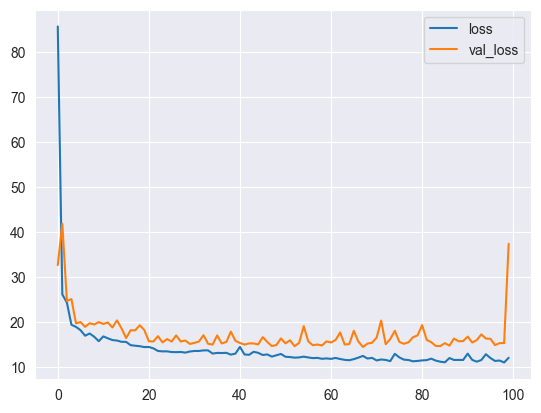

In [27]:
# 学習結果をプロット
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [33]:
# testデータで予測
test_predict = model.predict(test_datasets)



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step
test_predict : [1.0000000e+00 1.1744462e-08 1.1070733e-13]
test_target_severity_list : [1. 0. 0.]
accuracy : 0.04


In [41]:
# 正答率を計算
correct_count = 0

# 重症度が高いものの正答率を計算
high_severity_correct_count = 0
high_severity_count = 0

for i in range(len(test_target_severity_list)):
    for j in range(25):
        print(f'test_target_severity_list : {test_target_severity_list[j][i]}')
        print(f'test_predict : {test_predict[j][i]}')
        if np.argmax(test_target_severity_list[j][i]) == np.argmax(test_predict[j][i]):
            correct_count += 1

        # 重症度が高いものの正答率を計算
        if (np.argmax(test_target_severity_list[j][i]) == SEVERE or
                np.argmax(test_target_severity_list[j][i]) == MODERATE):
            high_severity_count += 1
            if np.argmax(test_target_severity_list[j][i]) == np.argmax(test_predict[j][i]):
                high_severity_correct_count += 1

accuracy = correct_count / len(test_target_severity_list * 25)
print(f'accuracy : {accuracy}')

print(f'high_severity_count : {high_severity_count}')
high_severity_accuracy = high_severity_correct_count / high_severity_count
print(f'high_severity_accuracy : {high_severity_accuracy}')


test_target_severity_list : [1. 0. 0.]
test_predict : [1.0000000e+00 1.1744462e-08 1.1070733e-13]
test_target_severity_list : [1. 0. 0.]
test_predict : [1.0000000e+00 5.1530429e-11 2.2331333e-15]
test_target_severity_list : [1. 0. 0.]
test_predict : [1.000000e+00 3.577054e-08 1.784584e-15]
test_target_severity_list : [1. 0. 0.]
test_predict : [9.9995637e-01 4.3576707e-05 2.6867612e-08]
test_target_severity_list : [1. 0. 0.]
test_predict : [9.99885678e-01 1.14259354e-04 1.08148033e-08]
test_target_severity_list : [1. 0. 0.]
test_predict : [1.0000000e+00 7.0850432e-09 2.7864015e-20]
test_target_severity_list : [1. 0. 0.]
test_predict : [9.9999964e-01 3.9764558e-07 2.1145606e-16]
test_target_severity_list : [1. 0. 0.]
test_predict : [9.9992943e-01 7.0573013e-05 2.2658043e-12]
test_target_severity_list : [1. 0. 0.]
test_predict : [9.9748445e-01 2.5152485e-03 2.3134513e-07]
test_target_severity_list : [1. 0. 0.]
test_predict : [9.9123704e-01 8.3481492e-03 4.1485118e-04]
test_target_severity